In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from bandbLIMID import BranchAndBoundLIMIDInference
from exemple_robot import createIDRobot


maze=["---------",
      "--     --",
      "-  - -  -",
      "-- - - --",
      "-  - - $-",
      "--     --",
      "---------"]
nbStage=2
xInitial=3
yInitial=2
ID=createIDRobot(nbStage,xInitial,yInitial,maze)
#gnb.showInfluenceDiagram(ID)
ordre=[]
for i in range(nbStage):
    ordre.append(ID.idFromName("d_"+str(i)))
bnb=BranchAndBoundLIMIDInference(ID,ordre)
#gnb.showInfluenceDiagram(bnb.IDRelaxe)


In [2]:
bnb.branchAndBound()

_0 : 1
es_0 : 1
ss_0 : 0
ws_0 : 1
d_0 : 3
Erreur dans le postérieur
in not all processed
####################################################################################################################
####################################################################################################################
####################################################################################################################
####################################################################################################################
Nouvelle Branche, nombre de branche au total: 70 nombre de branches coupées: 0
On va développer le noeud d_0 id 35 On va donc chercher les parents du noeud d_1
Le domaine de d_0 : ['0', '1', '2', '3', '4'] ,les valeurs déjà processed: ['0', '1', '2', '3'] ce qu'on va process : 4
d_0 de contexte :
ns_0 : 1
es_0 : 1
ss_0 : 0
ws_0 : 1
d_0 : 4
Les parents de  d_1  sont :  ['ns_1', 'es_1', 'ss_1', 'ws_1']
ajout d'une couche, de racine, ns_1 ave

In [3]:
andOrGraph,npCoupe=bnb.getAndOrGraph()
decisions=andOrGraph.getNoeudDecision()
print(len(decisions))
print(npCoupe)
for node in decisions:
    print(node.getContexte())
    print(node.getDecisionOptimale())
    print(node.getValeurDecisionOptimale())

{2: '1', 3: '1', 4: '1', 5: '0', 50000: '0', 8: '0', 9: '0', 10: '0', 11: '0'}
0
(0.02086658399273766, 0.020431169665211683)
{2: '1', 3: '1', 4: '1', 5: '0', 50000: '0', 8: '0', 9: '0', 10: '0', 11: '1'}
0
(0.02086658399273766, 0.020431169665211683)
{2: '1', 3: '1', 4: '1', 5: '0', 50000: '0', 8: '0', 9: '0', 10: '1', 11: '0'}
0
(0.02086658399273766, 0.020431169665211683)
{2: '1', 3: '1', 4: '1', 5: '0', 50000: '0', 8: '0', 9: '0', 10: '1', 11: '1'}
0
(0.02086658399273766, 0.020431169665211683)
{2: '1', 3: '1', 4: '1', 5: '0', 50000: '0', 8: '0', 9: '1', 10: '0', 11: '0'}
0
(0.02086658399273766, 0.020431169665211683)
{2: '1', 3: '1', 4: '1', 5: '0', 50000: '0', 8: '0', 9: '1', 10: '0', 11: '1'}
0
(0.02086658399273766, 0.020431169665211683)
{2: '1', 3: '1', 4: '1', 5: '0', 50000: '0', 8: '0', 9: '1', 10: '1', 11: '0'}
0
(0.02086658399273766, 0.020431169665211683)
{2: '1', 3: '1', 4: '1', 5: '0', 50000: '0', 8: '0', 9: '1', 10: '1', 11: '1'}
0
(0.02086658399273766, 0.020431169665211683)


ajout d'une couche, de racine, A avec les noeuds de décisions crées étants : ['B', 'B'] de taille 2
Calcul des évaluations pour les noeuds de décisions


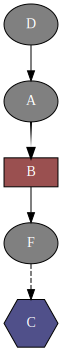

----
{1: '0'}
1
(18.437549544675782, 13.191177516423693)
----
{1: '1'}
1
(18.437549544675782, 13.191177516423693)


In [17]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from bandbLIMID import BranchAndBoundLIMIDInference
from exemple_robot import createIDRobot
ID=gum.fastID('D->A->*B->F->$C')
bnb=BranchAndBoundLIMIDInference(ID,[ID.idFromName('B')])
bnb.branchAndBound()
andOrGraph,npCoupe=bnb.getAndOrGraph()
decisions=andOrGraph.getNoeudDecision()
gnb.showInfluenceDiagram(ID,bnb.fromAndORGraphToDiGraph())
gnb.sideBySide(*[ID.cpt(i) for i in ID.nodes() if ID.isChanceNode(i)])
for node in decisions:
    print("----")
    print(node.getContexte())
    print(node.getDecisionOptimale())
    print(node.getValeurDecisionOptimale())